## ML Challenges

This notebook includes various code snippets mentioned in the first chapter of our Machine Learning Design Patterns book.

In [1]:
import pandas as pd
import tensorflow as tf

from sklearn.utils import shuffle
from google.cloud import bigquery

### Repeatability

Because of the inherent randomness in ML, there are additional measures required to ensure repeatability and reproducability between training and evaluation runs.

In [2]:
# Setting a random seed in TensorFlow
# Do this before you run training to ensure reproducible evaluation metrics
# You can use whatever value you'd like for the seed
tf.random.set_seed(2)

In [3]:
%%sh
wget -O gcp.json 'https://docs.google.com/uc?export=download&id=11IfhkCX1keJvsM10YGx9eepNIjB4Pi12&confirm=t'

--2024-08-19 17:15:00--  https://docs.google.com/uc?export=download&id=11IfhkCX1keJvsM10YGx9eepNIjB4Pi12&confirm=t
Resolving docs.google.com (docs.google.com)... 173.194.216.138, 173.194.216.102, 173.194.216.139, ...
Connecting to docs.google.com (docs.google.com)|173.194.216.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=11IfhkCX1keJvsM10YGx9eepNIjB4Pi12&export=download [following]
--2024-08-19 17:15:00--  https://drive.usercontent.google.com/download?id=11IfhkCX1keJvsM10YGx9eepNIjB4Pi12&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.134.132, 2607:f8b0:400c:c00::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.134.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2369 (2.3K) [application/octet-stream]
Saving to: ‘gcp.json’

     0K ..                                                    10

In [4]:
credentials_path = "gcp.json"
bq = bigquery.Client.from_service_account_json(credentials_path)

You also need to consider randomness when preparing your training, test, and validation datasets. To ensure consistency, prepare a shuffled dataset before training by setting a random seed value.

First, let's look at an example without shuffling. We'll grab some data from the NOAA storms public dataset in BigQuery. You'll need a Google Cloud account to run the cells that use this dataset.

Replace `your-cloud-project` below with the name of your Google Cloud project.

In [5]:
query = """
SELECT
  *
FROM
  `bigquery-public-data.noaa_historic_severe_storms.storms_*`
LIMIT 1000
"""
df = bq.query(query).to_dataframe()
df

,episode_id,event_id,state,state_fips_code,event_type,cz_type,cz_fips_code,cz_name,wfo,event_begin_time,...,tor_length,tor_width,tor_other_wfo,location_index,event_range,event_azimuth,reference_location,event_latitude,event_longitude,event_point
0,None,10047282,Mi,28,tornado,C,87,LOWNDES,None,1951-09-09 09:15:00,...,0.1,100,None,None,NaN,None,None,NaN,NaN,None
1,None,10028729,Ka,20,tornado,C,63,GOVE,None,1951-06-17 22:00:00,...,0.7,33,None,None,NaN,None,None,NaN,NaN,None
2,None,10120421,Te,48,tornado,C,225,HOUSTON,None,1951-03-28 05:10:00,...,0.5,17,None,None,NaN,None,None,NaN,NaN,None
3,None,10099717,Ok,40,tornado,C,33,COTTON,None,1951-05-09 18:30:00,...,0.0,33,None,None,NaN,None,None,NaN,NaN,None
4,None,10099742,Ok,40,tornado,C,73,KINGFISHER,None,1951-07-15 16:20:00,...,0.0,100,None,None,NaN,None,None,NaN,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,None,10105303,Ok,40,hail,C,51,GRADY,OKC,1986-06-10 15:00:00,...,0.0,0,None,None,NaN,None,None,NaN,NaN,None
996,None,10105304,Ok,40,thunderstorm wind,C,33,COTTON,OKC,1986-06-10 15:00:00,...,0.0,0,None,None,NaN,None,None,NaN,NaN,None
997,None,10105305,Ok,40,hail,C,51,GRADY,OKC,1986-06-10 15:15:00,...,0.0,0,None,None,NaN,None,None,NaN,NaN,None
998,None,10105306,Ok,40,hail,C,109,OKLAHOMA,OKC,1986-06-10 15:15:00,...,0.0,0,None,None,NaN,None,None,NaN,NaN,None


Run the cell below multiple times, and notice that the order of the data changes each time.

In [6]:
storms_df = shuffle(storms_df)
storms_df.head()

NameError: name 'storms_df' is not defined

Next, repeat the above but set a random seed. Note that the data order stays the same even when run multiple times.



In [ ]:
shuffled_df = shuffle(storms_df, random_state=2)
shuffled_df.head()

,episode_id,event_id,state,state_fips_code,event_type,cz_type,cz_fips_code,cz_name,wfo,event_begin_time,event_timezone,event_end_time,injuries_direct,injuries_indirect,deaths_direct,deaths_indirect,damage_property,damage_crops,source,magnitude,magnitude_type,flood_cause,tor_f_scale,tor_length,tor_width,tor_other_wfo,location_index,event_range,event_azimuth,reference_location,event_latitude,event_longitude,event_point
888,None,10082557,New hampshire,33,thunderstorm wind,C,13,MERRIMACK,CON,1990-10-18 21:00:00,CST,1990-10-18 21:00:00,0,0,0,0,0,0,None,0.0,None,None,None,0,0,None,None,None,None,None,None,None,None
185,None,10111136,South carolina,45,thunderstorm wind,C,3,AIKEN,AGS,1990-05-28 10:30:00,CST,1990-05-28 10:30:00,0,0,0,0,0,0,None,0.0,None,None,None,0,0,None,None,None,None,None,None,None,None
975,None,10049089,Minnesota,27,thunderstorm wind,C,13,BLUE EARTH,RST,1990-06-02 11:40:00,CST,1990-06-02 11:40:00,1,0,0,0,0,0,None,0.0,None,None,None,0,0,None,None,None,None,None,None,None,None
684,None,10147552,West virginia,54,thunderstorm wind,C,9,BROOKE,PIT,1990-09-06 15:30:00,CST,1990-09-06 15:30:00,0,0,0,0,0,0,None,0.0,None,None,None,0,0,None,None,None,None,None,None,None,None
45,None,10054154,Michigan,26,thunderstorm wind,C,1,ALCONA,APN,1990-10-04 13:00:00,CST,1990-10-04 13:00:00,0,0,0,0,0,0,None,0.0,None,None,None,0,0,None,None,None,None,None,None,None,None


### Data drift

It's important to analyze how data is changing over time to ensure your ML models are trained on accurate data. To demonstrate this, we'll use the same NOAA storms dataset as above with a slightly different query.

Let's look at how the number of reported storms has increased over time.

In [8]:
query = """
SELECT
  SUBSTR(CAST(event_begin_time AS string), 1, 4) AS year,
  COUNT(*) AS num_storms
FROM
  `bigquery-public-data.noaa_historic_severe_storms.storms_*`
GROUP BY
  year
ORDER BY
  year ASC
"""
storm_trends = bq.query(query).to_dataframe()
storm_trends

,year,num_storms
0,1950,223
1,1951,269
2,1952,272
3,1953,492
4,1954,609
...,...,...
70,2020,85311
71,2021,83083
72,2022,83342
73,2023,91375


In [9]:
storm_trends.head()

,year,num_storms
0,1950,223
1,1951,269
2,1952,272
3,1953,492
4,1954,609


As seen below, training a model on data before 2000 to predict storms now would result in incorrect predictions.

<Axes: title={'center': 'Storm trends over time'}, xlabel='year'>

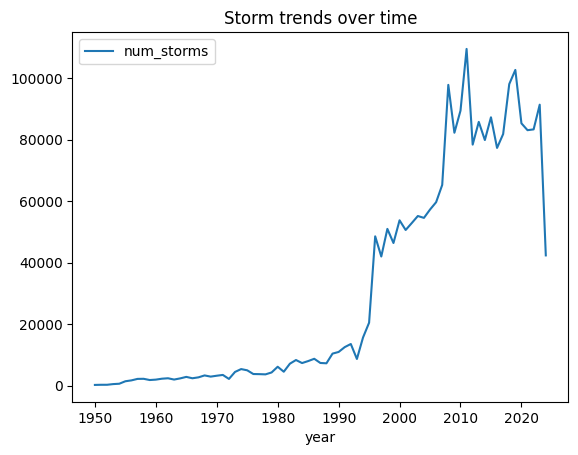

In [10]:
storm_trends.plot(title='Storm trends over time', x='year', y='num_storms')

Copyright 2020 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License